In [ ]:
This script describes the functionality of the flat-sky version of pymaster

In [ ]:
from __future__ import print_function
from __future__ import division

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Import the NaMaster python wrapper
import pymaster as nmt

In [2]:
# Dimensions: First, a flat-sky field is defined by four quantities:

# 1) Lx and Ly: the size of the patch in the x and y dimensions (in radians)
Lx = 72. * np.pi / 180.
Ly = 48. * np.pi / 180.

# 2) Nx and Ny: the number of pixels in the x and y dimensions
Nx = 602
Ny = 410

Gaussian simulations:

`pymaster` allows you to generate random realizations of both spherical and flat fields given a power spectrum. These are returned as 2D arrays with shape `(Ny, Nx)`.

In [6]:
l, cl_tt, cl_ee, cl_bb, cl_te=np.loadtxt('../test/cls.txt', unpack=True)
beam = np.exp(-(0.25 * np.pi/180. * l)**2)
cl_tt *= beam
cl_ee *= beam
cl_bb *= beam
cl_te *= beam
mpt, mpq, mpu = nmt.synfast_flat(Nx, Ny, Lx, Ly, [cl_tt, cl_ee, cl_bb, cl_te], pol=True)

You can have a look at the maps using `pyplot.imshow()`:

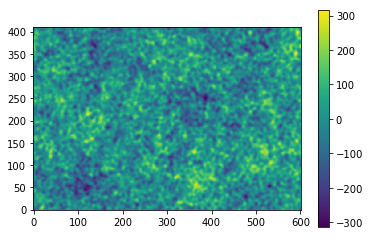

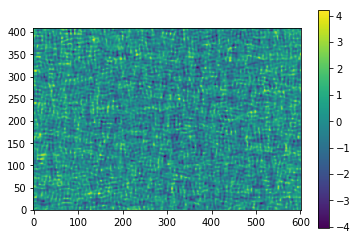

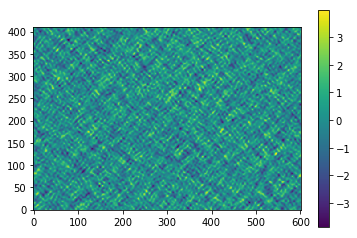

In [7]:
plt.figure()
plt.imshow(mpt, interpolation='nearest', origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(mpq, interpolation='nearest', origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(mpu, interpolation='nearest', origin='lower')
plt.colorbar();

In [8]:
# Let's now create a mask:
mask = np.ones_like(mpt).flatten()
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx / Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly / Ny

In [9]:
# First we dig a couple of holes

def dig_hole(x, y, r):
    rad=(np.sqrt((xarr - x)**2 + (yarr - y)**2)).flatten()
    return np.where(rad < r)[0]

mask[dig_hole(0.3 * Lx, 0.6 * Ly, 0.05 * np.sqrt(Lx * Ly))] = 0.
mask[dig_hole(0.7 * Lx, 0.12 * Ly, 0.07 * np.sqrt(Lx * Ly))] = 0.
mask[dig_hole(0.7 * Lx, 0.8 * Ly, 0.03 * np.sqrt(Lx * Ly))] = 0.

In [10]:
# Let's also trim the edges
mask[np.where(xarr.flatten() < Lx / 16.)] = 0
mask[np.where(xarr.flatten() > 15 * Lx / 16.)] = 0

mask[np.where(yarr.flatten() < Ly / 16.)] = 0
mask[np.where(yarr.flatten() > 15 * Ly / 16.)] = 0

mask = mask.reshape([Ny, Nx])

In [11]:
# You can also apodize it in the same way you do for full-sky masks:
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=2., apotype="C1")

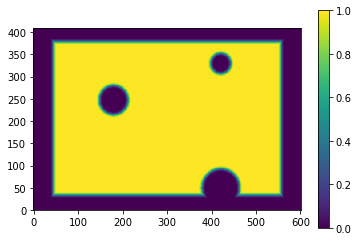

In [12]:
plt.figure()
plt.imshow(mask, interpolation='nearest', origin='lower')
plt.colorbar()

Fields:
    
Once you have maps it's time to create pymaster fields. Note that, as in the full-sky case, you can also pass contaminant templates and flags for E and B purification (see the documentation for more details)

In [13]:
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [mpt])
f2 = nmt.NmtFieldFlat(Lx, Ly, mask, [mpq, mpu], purify_b=True)

If you compute the power spectrum of two fields (without caring for mode coupling), pymaster will return it with at a hard-coded resolution in ell-space determined by the size and number of pixels of the patch.

You can get the list of ells at which this is done by calling the following function:

`ells_coupled = f0.get_ell_sampling()`

Bins:

For flat-sky fields, bandpowers are simply defined as intervals in ell, and `pymaster` doesn't currently support any weighting scheme within each interval.

In [14]:
l0_bins = np.arange(Nx / 8) * 8 * np.pi / Lx
lf_bins = (np.arange(Nx / 8) + 1) * 8 * np.pi / Lx
b = nmt.NmtBinFlat(l0_bins, lf_bins)

In [ ]:
# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

Workspaces:

As in the full-sky case, the computation of the coupling matrix and of the pseudo-$C_L$ estimator is mediated by a `WorkspaceFlat` case, initialized by calling its compute_coupling_matrix method:

In [ ]:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)

In [ ]:
w02 = nmt.NmtWorkspaceFlat()
w02.compute_coupling_matrix(f0, f2, b)

In [ ]:
w22 = nmt.NmtWorkspaceFlat()
w22.compute_coupling_matrix(f2, f2, b)

In [ ]:
# Workspaces can be saved to and read from disk to avoid recomputing them:
w00.write_to("w00_flat.dat")
w00.read_from("w00_flat.dat")

w02.write_to("w02_flat.dat")
w02.read_from("w02_flat.dat")

w22.write_to("w22_flat.dat")
w22.read_from("w22_flat.dat")

Computing power spectra:

As in the full-sky case, you compute the pseudo-$C_L$ estimator by computing the coupled power spectra and then decoupling them by inverting the mode-coupling matrix. This is done in two steps below, but pymaster provides convenience routines to do this through a single function call.

In [ ]:
cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0)
cl00_uncoupled = w00.decouple_cell(cl00_coupled)

cl02_coupled = nmt.compute_coupled_cell_flat(f0, f2)
cl02_uncoupled = w02.decouple_cell(cl02_coupled)

cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2)
cl22_uncoupled = w22.decouple_cell(cl22_coupled)

In [ ]:
# Let's look at the results!
plt.figure()
plt.plot(l, cl_tt, 'r-', label='Input TT')
plt.plot(l, cl_ee, 'g-', label='Input EE')
plt.plot(l, cl_bb, 'b-', label='Input BB')
plt.plot(ells_uncoupled, cl00_uncoupled[0], 'r--', label='Uncoupled')
plt.plot(ells_coupled, cl00_coupled[0], 'r-.', label='Coupled')
plt.plot(ells_uncoupled, cl22_uncoupled[0], 'g--')
plt.plot(ells_coupled, cl22_coupled[0], 'g-.')
plt.plot(ells_uncoupled, cl22_uncoupled[3], 'b--')
plt.plot(ells_coupled, cl22_coupled[3], 'b-.')
plt.loglog()